## Part 1. Obtain Groove Values

In [ ]:
!pip install essentia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 32.8 MB/s eta 0:00:00


In [ ]:
# Access audio files in our shared Drive
import os
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/Shareddrives/MIR Final Project'
os.chdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necesary libraries
from pathlib import Path
import essentia
import essentia.standard as es
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import IPython.display as ipd
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
import librosa
import librosa.display, os
import matplotlib.pyplot as plt
import torch
import librosa
from essentia import *
from essentia.standard import *

In [ ]:
# Make a .csv file of all the filenames in the dataset (just in case)

dir = os.path.join(path, 'Dataset/Audios')
data_file = 'filenames.csv'

overwrite = False

if not Path(data_file).is_file or overwrite:
  # It also creates a list of all the fileNames
  fileNames = []
  with open(data_file, 'w') as writer:
    for subpath, _, files in os.walk(dir):
      for name in files:
        fileName = os.path.relpath(os.path.join(subpath,name), path)
        fileNames.append([fileName])
        line2write = fileName + '\n'
        writer.write(line2write)

In [ ]:
# Creates the list of the fileNames without rewriting the .csv
with open('filenames.csv', 'r') as fp:
  fnReader = csv.reader(fp)
  fileNames = list(fnReader)

In [ ]:
# Example analysis
sample_file = random.choice(fileNames)[0]
fs = 44100
x = es.MonoLoader(filename = sample_file, sampleRate = fs)()
print(f'Sample_file = {sample_file}')
plt.plot(x)
ipd.Audio(x, rate=fs)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Compute beat positions
bpm, beats, _, _, _ = es.RhythmExtractor2013(method="multifeature")(x)

# Swing calculations
beat_durations = essentia.array([beats[i+1] - beats[i] for i in range(len(beats)-1)])
avg_beat_duration = sum(beat_durations) / len(beat_durations)

swing = essentia.array([abs(beat_durations[i] - avg_beat_duration) for i in range(len(beat_durations))])
meanSwing = np.mean(swing)

# Swing as percentage
swingValue = (meanSwing / avg_beat_duration) * 100

print(f'The Groove/Swing value for the example track is: {swingValue:.2f}')

The Groove/Swing value for the example track is: 1.21


In [ ]:
start = 0
# overwrite = True
overwrite = False

if not Path('processed.csv').is_file or overwrite:
    mode = 'w'
else:
    with open('processed.csv', 'r') as pr:
        prReader = csv.reader(pr)
        start = sum(1 for line in prReader) - 1
        print(f'{start} files already processed')
        mode = 'a'
with open('processed.csv', mode) as writer:
    if mode == 'w':
        line2write = 'Filename\tGroove_value\n'
        writer.write(line2write)
    for counter in tqdm(range(start, len(fileNames))):
        sample_file = fileNames[counter][0]
        x = es.MonoLoader(filename = sample_file, sampleRate = fs)()
        
        # Beat positions extraction
        _, beats, _, _, _ = es.RhythmExtractor2013(method="multifeature")(x)
        
        # Swing calculations
        beat_durations = essentia.array([beats[i+1] - beats[i] for i in range(len(beats)-1)])
        avg_beat_duration = sum(beat_durations) / len(beat_durations)

        swing = essentia.array([abs(beat_durations[i] - avg_beat_duration) for i in range(len(beat_durations))])
        meanSwing = np.mean(swing)

        # Swing as percentage
        grooveValue = (meanSwing / avg_beat_duration) * 100

        line2write = f'{sample_file}\t{grooveValue}\n'
        writer.write(line2write)

'if not Path(\'processed.csv\').is_file or overwrite:\n    mode = \'w\'\nelse:\n    with open(\'processed.csv\', \'r\') as pr:\n        prReader = csv.reader(pr)\n        start = sum(1 for line in prReader) - 1\n        print(f\'{start} files already processed\')\n        mode = \'a\'\nwith open(\'processed.csv\', mode) as writer:\n    if mode == \'w\':\n        line2write = \'Filename\tGroove_value\n\'\n        writer.write(line2write)\n    for counter in tqdm(range(start, len(fileNames))):\n        sample_file = fileNames[counter][0]\n        x = es.MonoLoader(filename = sample_file, sampleRate = fs)()\n        \n        # Beat positions extraction\n        _, beats, _, _, _ = es.RhythmExtractor2013(method="multifeature")(x)\n        \n        # Swing calculations\n        beat_durations = essentia.array([beats[i+1] - beats[i] for i in range(len(beats)-1)])\n        avg_beat_duration = sum(beat_durations) / len(beat_durations)\n\n        swing = essentia.array([abs(beat_durations[i] 

## Part 2. Data Preparation

In [ ]:
from essentia.standard import *
from tempfile import TemporaryDirectory

In [ ]:
# We tried using inset detection but it did not really work
def generate_onsets_from_directory(input_folder, output_folder):
    dir = os.listdir(input_folder)

    for i, file in enumerate(dir):
        input_file = os.path.join(input_folder, file)
        output_file = os.path.join(output_folder, file.replace('.mp3', '.png'))
        audio = MonoLoader(filename = input_file)()
        od_complex = OnsetDetection(method='complex')
        w = Windowing(type='hann')
        fft = FFT() # Outputs a complex FFT vector.
        c2p = CartesianToPolar() # Converts it into a pair of magnitude and phase vectors.
        # Compute both ODF frame by frame. Store results to a Pool.
        pool = essentia.Pool()
        for frame in FrameGenerator(audio, frameSize=1024, hopSize=512):
            magnitude, phase = c2p(fft(w(frame)))
            pool.add('odf.complex', od_complex(magnitude, phase))
        plt.plot(pool['odf.complex'][:2583])
        plt.show()

In [ ]:
generate_onsets_from_directory('/content/drive/Shareddrives/MIR Final Project/Dataset/Audios/Vallenato/', '')

In [ ]:
# We tried an onset detection example from Essentia

from essentia.standard import *
from tempfile import TemporaryDirectory


# Load audio file.
audio = MonoLoader(filename='/content/drive/Shareddrives/MIR Final Project/Dataset/Audios/Bachata/bachata0000.mp3')()

# 1. Compute the onset detection function (ODF).

# The OnsetDetection algorithm provides various ODFs.
od_hfc = OnsetDetection(method='hfc')
od_complex = OnsetDetection(method='complex')

# We need the auxilary algorithms to compute magnitude and phase.
w = Windowing(type='hann')
fft = FFT() # Outputs a complex FFT vector.
c2p = CartesianToPolar() # Converts it into a pair of magnitude and phase vectors.

# Compute both ODF frame by frame. Store results to a Pool.
pool = essentia.Pool()
for frame in FrameGenerator(audio, frameSize=1024, hopSize=512):
    magnitude, phase = c2p(fft(w(frame)))
    pool.add('odf.complex', od_complex(magnitude, phase))

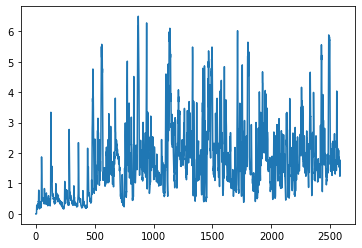

In [ ]:
plt.plot(pool['odf.complex'])
plt.xlabel('Time')
plt.ylabel('ODF')

In [ ]:
# Our first approach is using spectrogram, which is showed in the rest of the notebook
%matplotlib inline

def create_spectrogram(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)


    y, sr = librosa.load(audio_file)
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file)
    plt.close(fig)
    
def create_pngs_from_wavs(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    dir = os.listdir(input_path)

    for i, file in enumerate(dir):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file.replace('.mp3', '.png'))
        create_spectrogram(input_file, output_file)

In [ ]:
# Create PNG files containing spectrograms from all the WAV files in the "Dataset/Audios/Bachata" directory
create_pngs_from_wavs('Dataset/Audios/Bachata', 'Dataset/Spectrograms/Bachata')

In [ ]:
# Create PNG files containing spectrograms from all the WAV files in the "Dataset/Audios/Cumbia" directory
create_pngs_from_wavs('Dataset/Audios/Cumbia', 'Dataset/Spectrograms/Cumbia')

In [ ]:
# Create PNG files containing spectrograms from all the WAV files in the "Dataset/Audios/Merengue" directory
create_pngs_from_wavs('Dataset/Audios/Merengue', 'Dataset/Spectrograms/Merengue')

In [ ]:
# Create PNG files containing spectrograms from all the WAV files in the "Dataset/Audios/Salsa" directory
create_pngs_from_wavs('Dataset/Audios/Salsa', 'Dataset/Spectrograms/Salsa')

In [ ]:
# Create PNG files containing spectrograms from all the WAV files in the "Dataset/Audios/Vallenato" directory
create_pngs_from_wavs('Dataset/Audios/Vallenato', 'Dataset/Spectrograms/Vallenato')

In [ ]:
#from keras.preprocessing import image
from PIL import Image
#from tensorflow.keras.preprocessing.image import load_img

def load_images_from_path(path, label):
    images = []
    labels = []

    for file in os.listdir(path):
      #print(file)
      #images.append(image.img_to_array(image.load_img(os.path.join(path, file), target_size=(224, 224, 3))))
      # Load an image using PIL
      img_pil = Image.open(os.path.join(path, file)).convert('RGB')

      # Resize the image to target size of (224, 224) with bicubic interpolation
      img_pil_resized = img_pil.resize((224, 224), resample=Image.BICUBIC)

      # Convert the PIL object to a NumPy array and add an additional dimension for the channel
      img_np = np.array(img_pil_resized).reshape((224, 224, 3))

      # Convert the PIL object to a NumPy array
      #img_np = np.asarray(img_pil)

      images.append(np.array(img_np))
      #print(label[label['Filename'] == os.path.join(path, file)]['Groove_value'])
      #print(os.path.join(path, file))
      labels.append((label[label['Filename'] == os.path.join(path, file)]['Groove_value']))
        
    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)
        
x = []
y = []


In [ ]:
# Our labels are the groovines values
# Import the csv wiht the groovines values
df_processed = pd.read_csv('OK_processed.csv')

# Split string column into two new columns
df_processed['Filename'] = df_processed['Filename'].str.replace(',','.')
df_processed['Filename'] = df_processed['Filename'].replace('.mp3','.png', regex=True)
df_processed['Filename'] = df_processed['Filename'].replace('Audios','Spectrograms', regex=True)
df_processed['Groove_value'] = df_processed['Groove_value'].str.replace(',','.')
df_processed = df_processed.sort_values('Filename')
df_processed = df_processed.set_index(pd.Series(np.arange(1500)))
df_processed.head()

,Filename,Groove_value
0,Dataset/Spectrograms/Bachata/bachata0000.png,3.050746839
1,Dataset/Spectrograms/Bachata/bachata0001.png,4.997291113
2,Dataset/Spectrograms/Bachata/bachata0002.png,1.310799417
3,Dataset/Spectrograms/Bachata/bachata0003.png,1.194270799
4,Dataset/Spectrograms/Bachata/bachata0004.png,2.527634397


In [ ]:
# General classes not divided equially
classes_groove = []
for i in range(len(df_processed['Groove_value'])):
  classes_groove.append(np.floor(float(df_processed['Groove_value'][i]) / 1))

In [ ]:
# Equally divided classes
groove_values2 = df_processed['Groove_value']
groove_values = []

for i in range(1500): #len(groove_values)):
    groove_values.append(float(groove_values2[i]))

# Calculate the minimum and maximum values in classes_groove
min_val = 0.1 #np.min(groove_values)
max_val = 20.0 #np.max(groove_values)

# Take the logarithm of min_val and max_val
log_min_val = np.log10(min_val)
log_max_val = np.log10(max_val)

# Choose the number of intervals
n = 20

# Calculate the size of each interval
size = (log_max_val - log_min_val) / n

# Calculate the boundaries of each interval
boundaries = [np.power(10, log_min_val + i * size) for i in range(n+1)]

# Use np.digitize to assign each value to an interval
classes_groove = np.digitize(groove_values, boundaries)

In [ ]:
np.unique(classes_groove, return_counts=True)

(array([ 0,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21]),
 array([  5,   1,   4,   4,  18,  21,  59, 173, 351, 390, 274,  55,  36,
         24,  30,  17,  19,  11,   5,   3]))

In [ ]:
len(np.unique(classes_groove))

20

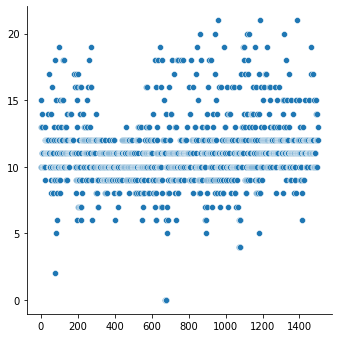

In [ ]:
import seaborn as sns
sns.relplot(data=classes_groove)

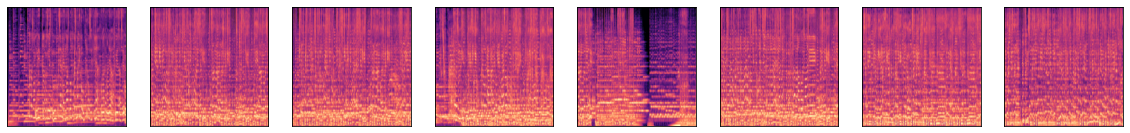

In [ ]:
# Map each spectogram to its groove value
images, labels = load_images_from_path('Dataset/Spectrograms/Bachata', df_processed)
show_images(images)
    
x += images
y += labels

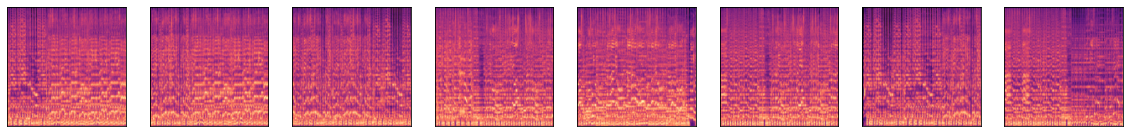

In [ ]:
# Map each spectogram to its groove value
images, labels = load_images_from_path('Dataset/Spectrograms/Cumbia', df_processed)
show_images(images)
    
x += images
y += labels

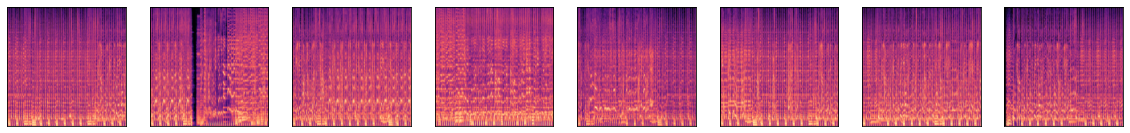

In [ ]:
# Map each spectogram to its groove value
images, labels = load_images_from_path('Dataset/Spectrograms/Merengue', df_processed)
show_images(images)
    
x += images
y += labels

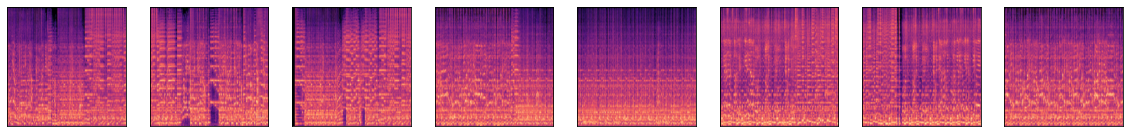

In [ ]:
# Map each spectogram to its groove value
images, labels = load_images_from_path('Dataset/Spectrograms/Salsa', df_processed)
show_images(images)
    
x += images
y += labels

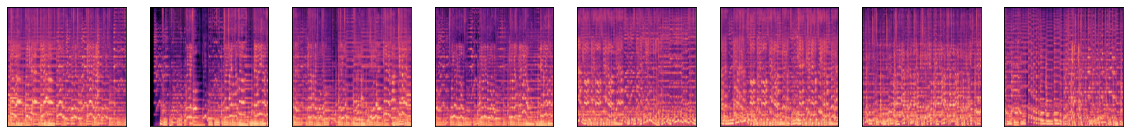

In [ ]:
# Map each spectogram to its groove value
images, labels = load_images_from_path('Dataset/Spectrograms/Vallenato', df_processed)
show_images(images)
    
x += images
y += labels

In [ ]:
x_array = np.array(x)
classes_groove_arr = np.array(classes_groove)

In [ ]:
x_array.shape

(1500, 224, 224, 3)

In [ ]:
classes_groove_arr.shape

(1500,)

In [ ]:
del x
del y
del classes_groove
del df_processed

## Part 3. Computing our CNN model

In [ ]:
# CNN with MSE
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(20, activation=None))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 109, 109, 128)     36992     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 54, 54, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 52, 52, 128)       147584    
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 26, 26, 128)     

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_array, classes_groove_arr, test_size=0.2, random_state=0)


In [ ]:
print(y_test.shape)
print(y_train.shape)

(300,)
(1200,)


In [ ]:
x_train.shape

(1200, 224, 224, 3)

In [ ]:
# Train the model
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=250)

Epoch 1/250
38/38 [==============================] - 3s 72ms/step - loss: 5.8372 - accuracy: 0.0450 - val_loss: 6.0025 - val_accuracy: 0.0300
Epoch 2/250
38/38 [==============================] - 3s 73ms/step - loss: 6.0726 - accuracy: 0.0483 - val_loss: 9.0425 - val_accuracy: 0.0300
Epoch 3/250
38/38 [==============================] - 3s 72ms/step - loss: 6.8079 - accuracy: 0.0425 - val_loss: 6.0050 - val_accuracy: 0.0533
Epoch 4/250
38/38 [==============================] - 3s 71ms/step - loss: 5.8282 - accuracy: 0.0492 - val_loss: 5.9314 - val_accuracy: 0.0500
Epoch 5/250
38/38 [==============================] - 3s 72ms/step - loss: 5.9259 - accuracy: 0.0392 - val_loss: 6.5906 - val_accuracy: 0.0167
Epoch 6/250
38/38 [==============================] - 3s 73ms/step - loss: 6.1008 - accuracy: 0.0617 - val_loss: 7.1284 - val_accuracy: 0.1067
Epoch 7/250
38/38 [==============================] - 3s 75ms/step - loss: 5.9769 - accuracy: 0.0317 - val_loss: 10.1019 - val_accuracy: 0.0100
Epoch

10/10 [==============================] - 0s 22ms/step


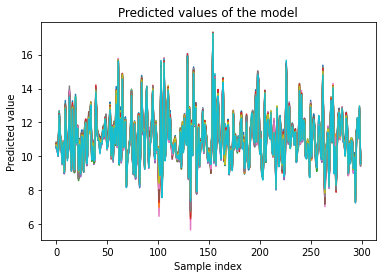

In [ ]:
# Evaluate the model
#test_loss, test_mae = model.evaluate(x_test, y_test)

# Make predictions
y_pred = model.predict(x_test)
#print(y_pred)
# Plot the predicted values
plt.plot(y_pred)

# Add axis labels and a title
plt.xlabel('Sample index')
plt.ylabel('Predicted value')
plt.title('Predicted values of the model')

# Show the plot
plt.show()

[]

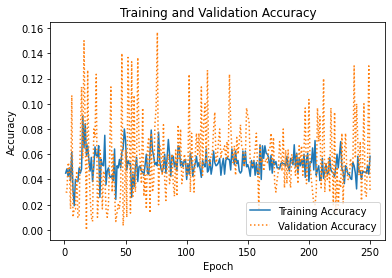

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [ ]:
print('Average accuracy of the model: ' + str(np.mean(acc)))
print('Average validation accuracy of the model: ' + str(np.mean(val_acc)))

Average accuracy of the model: 0.05169000010192394
Average validation accuracy of the model: 0.056600000275298955


[]

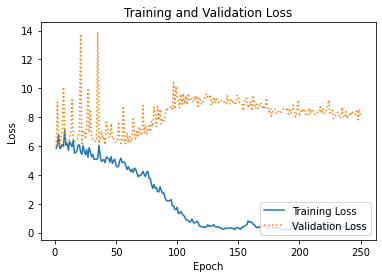

In [ ]:
acc = hist.history['loss']
val_acc = hist.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Loss')
plt.plot(epochs, val_acc, ':', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.plot()

In [ ]:
print('Average loss of the model: ' + str(np.mean(acc)))
print('Average validation loss of the model: ' + str(np.mean(val_acc)))

Average loss of the model: 2.1004618018865586
Average validation loss of the model: 8.17385803604126


In [ ]:
# CNN with Binary Cross Entropy
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(20, activation=None))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 109, 109, 128)     36992     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 54, 54, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 52, 52, 128)       147584    
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 26, 26, 128)     

In [ ]:
# Train the model
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=250)

Epoch 1/250
38/38 [==============================] - 5s 85ms/step - loss: -23.1523 - accuracy: 0.1208 - val_loss: -23.9733 - val_accuracy: 0.0900
Epoch 2/250
38/38 [==============================] - 3s 69ms/step - loss: -23.4692 - accuracy: 0.1217 - val_loss: -23.9733 - val_accuracy: 0.0900
Epoch 3/250
38/38 [==============================] - 3s 72ms/step - loss: -23.4692 - accuracy: 0.1217 - val_loss: -23.9733 - val_accuracy: 0.0900
Epoch 4/250
38/38 [==============================] - 3s 69ms/step - loss: -23.4692 - accuracy: 0.1217 - val_loss: -23.9733 - val_accuracy: 0.0900
Epoch 5/250
38/38 [==============================] - 3s 75ms/step - loss: -23.4692 - accuracy: 0.1217 - val_loss: -23.9733 - val_accuracy: 0.0900
Epoch 6/250
38/38 [==============================] - 3s 75ms/step - loss: -23.4692 - accuracy: 0.1217 - val_loss: -23.9733 - val_accuracy: 0.0900
Epoch 7/250
38/38 [==============================] - 3s 69ms/step - loss: -23.4692 - accuracy: 0.1217 - val_loss: -23.9733 -

10/10 [==============================] - 0s 21ms/step


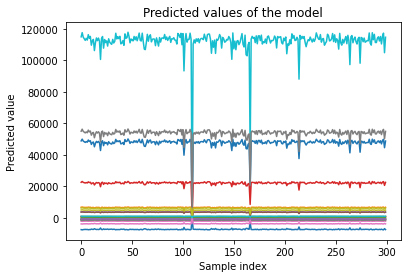

In [ ]:
# Make predictions
y_pred = model.predict(x_test)

# Plot the predicted values
plt.plot(y_pred)

# Add axis labels and a title
plt.xlabel('Sample index')
plt.ylabel('Predicted value')
plt.title('Predicted values of the model')

# Show the plot
plt.show()

[]

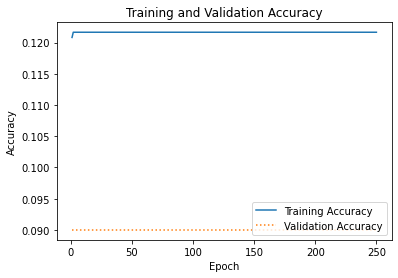

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [ ]:
print('Average accuracy of the model: ' + str(np.mean(acc)))
print('Average validation accuracy of the model: ' + str(np.mean(val_acc)))

Average accuracy of the model: 0.12166333648562432
Average validation accuracy of the model: 0.09000000357627869


[]

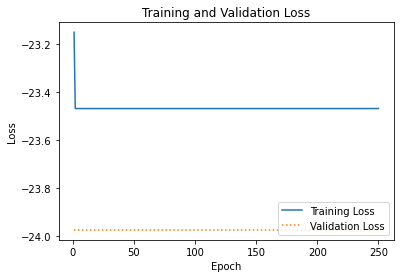

In [ ]:
acc = hist.history['loss']
val_acc = hist.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Loss')
plt.plot(epochs, val_acc, ':', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.plot()

In [ ]:
print('Average loss of the model: ' + str(np.mean(acc)))
print('Average validation loss of the model: ' + str(np.mean(val_acc)))

Average loss of the model: -23.46796314239502
Average validation loss of the model: -23.9732723236084
